<a href="https://colab.research.google.com/github/paritosh-Shukla24/Autogen_Agents/blob/main/L6_Planning_and_Stock_Report_Generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



> Add blockquote

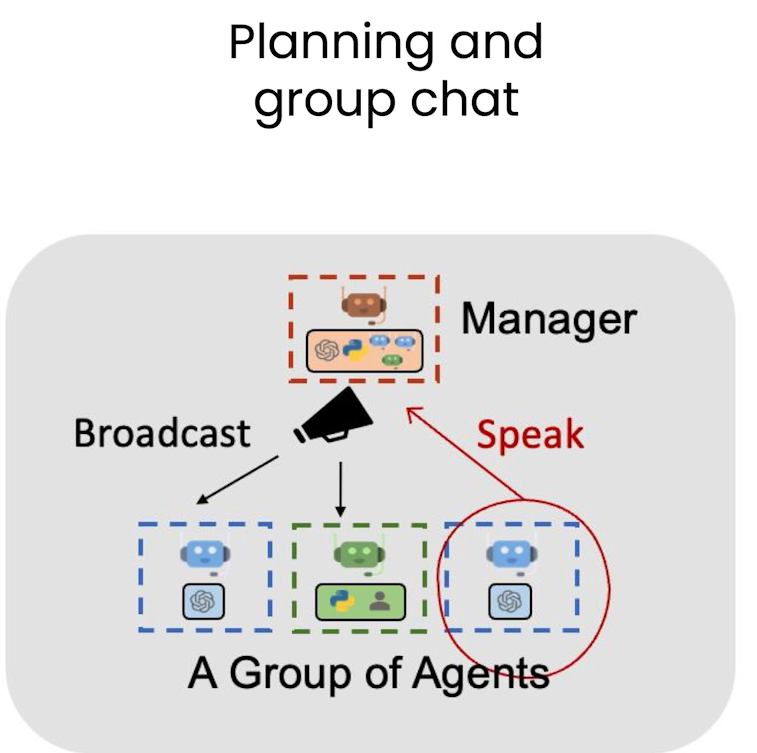

# Lesson 6: Planning and Stock Report Generation

## Setup

In [1]:
llm_config={"model": "gpt-4-turbo"}

In [2]:
import os
from google.colab import userdata
openai_api_key=userdata.get('OPENAI_API_KEY')
os.environ['OPENAI_MODEL_NAME']='gpt-4-turbo'
os.environ['OPENAI_API_KEY']=openai_api_key

## The task!

In [3]:
task = "Write a blogpost about the stock price performance of "\
"Nvidia in the past month. Today's date is 2024-04-23."

## Build a group chat

This group chat will include these agents:

1. **User_proxy** or **Admin**: to allow the user to comment on the report and ask the writer to refine it.
2. **Planner**: to determine relevant information needed to complete the task.
3. **Engineer**: to write code using the defined plan by the planner.
4. **Executor**: to execute the code written by the engineer.
5. **Writer**: to write the report.

In [5]:
!pip install autogen

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 350.1/350.1 kB 26.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 313.9/313.9 kB 21.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 55.1 MB/s eta 0:00:00


In [6]:
import autogen

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [7]:
user_proxy = autogen.ConversableAgent(
    name="Admin",
    system_message="Give the task, and send "
    "instructions to writer to refine the blog post.",
    code_execution_config=False,
    llm_config=llm_config,
    human_input_mode="ALWAYS",
)

In [8]:
planner = autogen.ConversableAgent(
    name="Planner",
    system_message="Given a task, please determine "
    "what information is needed to complete the task. "
    "Please note that the information will all be retrieved using"
    " Python code. Please only suggest information that can be "
    "retrieved using Python code. "
    "After each step is done by others, check the progress and "
    "instruct the remaining steps. If a step fails, try to "
    "workaround",
    description="Planner. Given a task, determine what "
    "information is needed to complete the task. "
    "After each step is done by others, check the progress and "
    "instruct the remaining steps",
    llm_config=llm_config,
)

In [9]:
engineer = autogen.AssistantAgent(
    name="Engineer",
    llm_config=llm_config,
    description="An engineer that writes code based on the plan "
    "provided by the planner.",
)

**Note**: In this lesson, you'll use an alternative method of code execution by providing a dict config. However, you can always use the LocalCommandLineCodeExecutor if you prefer. For more details about code_execution_config, check this: https://microsoft.github.io/autogen/docs/reference/agentchat/conversable_agent/#__init__

In [10]:
executor = autogen.ConversableAgent(
    name="Executor",
    system_message="Execute the code written by the "
    "engineer and report the result.",
    human_input_mode="NEVER",
    code_execution_config={
        "last_n_messages": 3,
        "work_dir": "coding",
        "use_docker": False,
    },
)

In [11]:
writer = autogen.ConversableAgent(
    name="Writer",
    llm_config=llm_config,
    system_message="Writer."
    "Please write blogs in markdown format (with relevant titles)"
    " and put the content in pseudo ```md``` code block. "
    "You take feedback from the admin and refine your blog.",
    description="Writer."
    "Write blogs based on the code execution results and take "
    "feedback from the admin to refine the blog."
)

## Define the group chat

In [12]:
groupchat = autogen.GroupChat(
    agents=[user_proxy, engineer, writer, executor, planner],
    messages=[],
    max_round=10,
)

In [13]:
manager = autogen.GroupChatManager(
    groupchat=groupchat, llm_config=llm_config
)


## Start the group chat!

<p style="background-color:#ECECEC; padding:15px; "> <b>Note:</b> In this lesson, you will use GPT 4 for better results. Please note that the lesson has a quota limit. If you want to explore the code in this lesson further, we recommend trying it locally with your own API key.

In [14]:
groupchat_result = user_proxy.initiate_chat(
    manager,
    message=task,
)

Admin (to chat_manager):

Write a blogpost about the stock price performance of Nvidia in the past month. Today's date is 2024-04-23.

--------------------------------------------------------------------------------

Next speaker: Planner


>>>>>>>> USING AUTO REPLY...
Planner (to chat_manager):

To write a blog post about the stock price performance of Nvidia in the past month, using Python code, you will need the following information:

1. **Historical Stock Prices** - You will need the daily closing prices of Nvidia's stock from March 23, 2024, to April 23, 2024.

2. **Analysis of Price Changes** - Calculate price changes, trends, highest and lowest prices during this period.

3. **Comparison Data** (Optional) - Comparing Nvidia's performance to overall market trends or to competitors' stock performances can provide additional insights.

4. **News or Events Impacting Stock** - Any specific news or events during this period that might have significantly impacted Nvidia's stock price.

## Add a speaker selection policy

In [15]:
user_proxy = autogen.ConversableAgent(
    name="Admin",
    system_message="Give the task, and send "
    "instructions to writer to refine the blog post.",
    code_execution_config=False,
    llm_config=llm_config,
    human_input_mode="ALWAYS",
)

planner = autogen.ConversableAgent(
    name="Planner",
    system_message="Given a task, please determine "
    "what information is needed to complete the task. "
    "Please note that the information will all be retrieved using"
    " Python code. Please only suggest information that can be "
    "retrieved using Python code. "
    "After each step is done by others, check the progress and "
    "instruct the remaining steps. If a step fails, try to "
    "workaround",
    description="Given a task, determine what "
    "information is needed to complete the task. "
    "After each step is done by others, check the progress and "
    "instruct the remaining steps",
    llm_config=llm_config,
)

engineer = autogen.AssistantAgent(
    name="Engineer",
    llm_config=llm_config,
    description="Write code based on the plan "
    "provided by the planner.",
)

writer = autogen.ConversableAgent(
    name="Writer",
    llm_config=llm_config,
    system_message="Writer. "
    "Please write blogs in markdown format (with relevant titles)"
    " and put the content in pseudo ```md``` code block. "
    "You take feedback from the admin and refine your blog.",
    description="After all the info is available, "
    "write blogs based on the code execution results and take "
    "feedback from the admin to refine the blog. ",
)

executor = autogen.ConversableAgent(
    name="Executor",
    description="Execute the code written by the "
    "engineer and report the result.",
    human_input_mode="NEVER",
    code_execution_config={
        "last_n_messages": 3,
        "work_dir": "coding",
        "use_docker": False,
    },
)

In [16]:
groupchat = autogen.GroupChat(
    agents=[user_proxy, engineer, writer, executor, planner],
    messages=[],
    max_round=10,
    allowed_or_disallowed_speaker_transitions={
        user_proxy: [engineer, writer, executor, planner],
        engineer: [user_proxy, executor],
        writer: [user_proxy, planner],
        executor: [user_proxy, engineer, planner],
        planner: [user_proxy, engineer, writer],
    },
    speaker_transitions_type="allowed",
)

In [17]:
manager = autogen.GroupChatManager(
    groupchat=groupchat, llm_config=llm_config
)

groupchat_result = user_proxy.initiate_chat(
    manager,
    message=task,
)

Admin (to chat_manager):

Write a blogpost about the stock price performance of Nvidia in the past month. Today's date is 2024-04-23.

--------------------------------------------------------------------------------

Next speaker: Planner


>>>>>>>> USING AUTO REPLY...
Planner (to chat_manager):

To write a blog post about the stock price performance of Nvidia in the past month, using Python code, you will need the following information:

1. **Historical Stock Prices** - You will need the daily closing prices of Nvidia's stock from March 23, 2024, to April 23, 2024.

2. **Analysis of Price Changes** - Calculate price changes, trends, highest and lowest prices during this period.

3. **Comparison Data** (Optional) - Comparing Nvidia's performance to overall market trends or to competitors' stock performances can provide additional insights.

4. **News or Events Impacting Stock** - Any specific news or events during this period that might have significantly impacted Nvidia's stock price.

**Note**: You might experience slightly different interactions between the agents. The engineer agent may write incorrect code, which the executor agent will report and send back for correction. This process could go through multiple rounds.